In [1]:
# 02_clustering.ipynb

import pandas as pd
from sklearn.cluster import KMeans
import umap
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


In [6]:
# Clean data
df = pd.read_csv("../data/listings_combined.csv")

columns = [
    'accommodates', 'bedrooms', 'bathrooms', 'beds', 'room_type',
    'price', 'review_scores_rating',
    'review_scores_cleanliness', 'review_scores_location', 'review_scores_value'
]

df_cleaned = df[columns]

# remove dollar signs and commas from price
df_cleaned['price'] = df_cleaned['price'].replace(r'[\$,]', '', regex=True).astype(float)

# Drop columns with too many missing values
df_cleaned = df_cleaned.dropna(axis=1, thresh=len(df_cleaned) * 0.5)

# Impute remaining NaNs with mean
df_cleaned = df_cleaned.fillna(df_cleaned.mean(numeric_only=True))
df_cleaned['review_scores_rating'] = pd.to_numeric(df_cleaned['review_scores_rating'], errors='coerce')
df_cleaned['review_scores_rating'].fillna(df_cleaned['review_scores_rating'].mean(), inplace=True)



print(df_cleaned)

/var/folders/kp/lylkft2d5sb4hg4fsm4ybb780000gn/T/ipykernel_72088/157351780.py:2: DtypeWarning: Columns (2,22,29,41,49,59,65) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/listings_combined.csv")


        accommodates  bedrooms  bathrooms  beds        room_type   price  \
0                2.0       1.0   1.000000   1.0     Private room    65.0   
1                3.0       0.0   1.000000   3.0  Entire home/apt   109.0   
2                2.0       1.0   1.000000   1.0  Entire home/apt   106.0   
3                2.0       1.0   1.602276   1.0  Entire home/apt   110.0   
4                1.0       1.0   1.000000   3.0  Entire home/apt   109.0   
...              ...       ...        ...   ...              ...     ...   
114350           4.0       1.0   1.000000   1.0  Entire home/apt   603.0   
114351          16.0       9.0   9.000000  10.0  Entire home/apt  2610.0   
114352           3.0       1.0   1.000000   2.0  Entire home/apt    80.0   
114353           2.0       0.0   0.500000   1.0  Entire home/apt   102.0   
114354           6.0       2.0   2.000000   2.0  Entire home/apt  1746.0   

        review_scores_rating  review_scores_cleanliness  \
0                   4.840000

/var/folders/kp/lylkft2d5sb4hg4fsm4ybb780000gn/T/ipykernel_72088/157351780.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['price'] = df_cleaned['price'].replace(r'[\$,]', '', regex=True).astype(float)


In [7]:
df_encoded = pd.get_dummies(df_cleaned, columns=['room_type'], drop_first=True)
print(df_encoded)

        accommodates  bedrooms  bathrooms  beds   price  review_scores_rating  \
0                2.0       1.0   1.000000   1.0    65.0              4.840000   
1                3.0       0.0   1.000000   3.0   109.0              4.830000   
2                2.0       1.0   1.000000   1.0   106.0              4.820000   
3                2.0       1.0   1.602276   1.0   110.0              4.900000   
4                1.0       1.0   1.000000   3.0   109.0              4.950000   
...              ...       ...        ...   ...     ...                   ...   
114350           4.0       1.0   1.000000   1.0   603.0              4.790139   
114351          16.0       9.0   9.000000  10.0  2610.0              4.790139   
114352           3.0       1.0   1.000000   2.0    80.0              4.790139   
114353           2.0       0.0   0.500000   1.0   102.0              4.790139   
114354           6.0       2.0   2.000000   2.0  1746.0              4.790139   

        review_scores_clean

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded)

In [ ]:
# UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(df_encoded)

/opt/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [ ]:
# KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
df_cleaned['cluster_kmeans'] = kmeans.fit_predict(X_umap)
sil_score = silhouette_score(X_umap, df_cleaned['cluster_kmeans'])
print(f"KMeans Silhouette Score: {sil_score:.2f}")

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans Silhouette Score: 0.35


In [ ]:
# Save with cluster labels
df_cleaned['cluster_kmeans'].to_csv("../data/listings_clustered.csv", index=False)

df_cluster = pd.read_csv("../data/listings_clustered.csv")
print(df['cluster_kmeans'])

0         3
1         3
2         3
3         1
4         3
         ..
114350    2
114351    1
114352    3
114353    1
114354    2
Name: cluster_kmeans, Length: 114355, dtype: int64


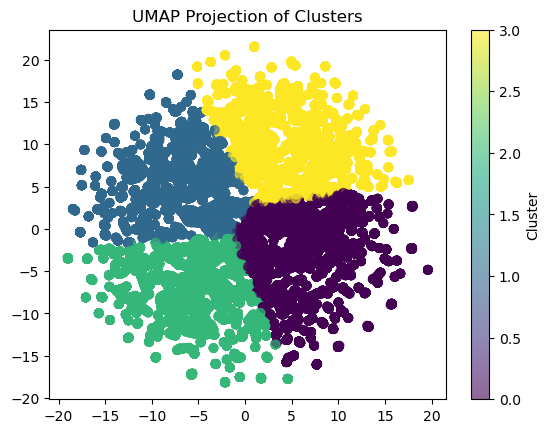

In [32]:
# Plot
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=df_cleaned['cluster_kmeans'], cmap='viridis', alpha=0.6)
plt.title("UMAP Projection of Clusters")
plt.colorbar(label='Cluster')
plt.show()

In [48]:
import joblib

df = pd.read_csv("../data/listings_combined.csv")

df_encoded['cluster'] = df_cleaned['cluster_kmeans']

df_encoded[['latitude', 'longitude']] = df[['latitude', 'longitude']]

cluster_labels = {
    0: "Mid-range",
    1: "Premium",
    2: "Luxury",
    3: "Budget"
}

df_encoded['cluster_label'] = df_encoded['cluster'].map(cluster_labels)


df_encoded.to_csv("../airbnb_app/airbnb_cluster.csv", index=False)
joblib.dump(kmeans, '../airbnb_app/kmeans_model.pkl')
joblib.dump(umap_model, '../airbnb_app/umap_model.pkl')

df_encoded

/var/folders/kp/lylkft2d5sb4hg4fsm4ybb780000gn/T/ipykernel_72088/4277435803.py:3: DtypeWarning: Columns (2,22,29,41,49,59,65) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/listings_combined.csv")


,accommodates,bedrooms,bathrooms,beds,price,review_scores_rating,review_scores_cleanliness,review_scores_location,review_scores_value,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,latitude,longitude,cluster,cluster_label
0,2.0,1.0,1.000000,1.0,65.0,4.840000,4.910000,4.89000,4.830000,False,False,True,False,33.846500,-118.082440,3,Budget
1,3.0,0.0,1.000000,3.0,109.0,4.830000,4.680000,4.70000,4.790000,True,False,False,False,33.985220,-118.359420,3,Budget
2,2.0,1.0,1.000000,1.0,106.0,4.820000,4.890000,4.94000,4.730000,True,False,False,False,34.082859,-118.278755,3,Budget
3,2.0,1.0,1.602276,1.0,110.0,4.900000,4.770000,4.93000,4.910000,True,False,False,False,34.128010,-118.319190,1,Premium
4,1.0,1.0,1.000000,3.0,109.0,4.950000,4.960000,4.95000,4.880000,True,False,False,False,34.057980,-118.355410,3,Budget
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114350,4.0,1.0,1.000000,1.0,603.0,4.790139,4.769622,4.82838,4.700659,True,False,False,False,20.922450,-156.695230,2,Luxury
114351,16.0,9.0,9.000000,10.0,2610.0,4.790139,4.769622,4.82838,4.700659,True,False,False,False,20.944642,-156.690166,1,Premium
114352,3.0,1.0,1.000000,2.0,80.0,4.790139,4.769622,4.82838,4.700659,True,False,False,False,21.291099,-157.788792,3,Budget
114353,2.0,0.0,0.500000,1.0,102.0,4.790139,4.769622,4.82838,4.700659,True,False,False,False,21.399510,-157.744420,1,Premium
